In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
from torchvision.utils import make_grid
import joblib
import plotly.express as px
from sklearn.model_selection import train_test_split, learning_curve
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.manifold import TSNE
# import umap
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb
import lightgbm as lgb
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

image_size = 256

In [3]:
class base_Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=2, image_size=256, gf_dim=64):
        super(base_Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        self.label_emb = nn.Embedding(num_classes, z_dim)
        
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(200, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # 3 x 256 x 256
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        gen_input = torch.cat((z, label_emb), 1)
        output = self.main(gen_input.view(-1, self.z_dim*2, 1, 1))
        return output
    
class base_Discriminator(nn.Module):
    def __init__(self, num_classes=2, image_size=256, df_dim=32):
        super(base_Discriminator, self).__init__()
            # input is (3) x 256 x 256
        self.conv1 = nn.Conv2d(3, df_dim, 4, 2, 1, bias=False)
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim) x 128 x 128
        self.conv2 = nn.Conv2d(df_dim, df_dim * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(df_dim * 2)
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*2) x 64 x 64
        self.conv3 = nn.Conv2d(df_dim * 2, df_dim * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(df_dim * 4)
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*4) x 32 x 32
        self.conv4 = nn.Conv2d(df_dim * 4, df_dim * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(df_dim * 8)
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*8) x 16 x 16
        self.conv5 = nn.Conv2d(df_dim * 8, df_dim * 16, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(df_dim * 16)
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*16) x 8 x 8
        self.conv6 = nn.Conv2d(df_dim * 16, df_dim * 32, 4, 2, 1, bias=False)  
        self.bn5 = nn.BatchNorm2d(df_dim * 32)
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)  
        # state size: (df_dim*32) x 4 x 4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear((1024 + 256 + 512) * 4 * 4, 1)
        self.dense2 = nn.Linear((1024 + 256 + 512) * 4 * 4, num_classes)

    def forward(self, x):
        
        x = self.leaky1(self.conv1(x))
        x = self.leaky2(self.bn1(self.conv2(x)))
        x = self.leaky3(self.bn2(self.conv3(x)))
        x = self.leaky4(self.bn3(self.conv4(x)))
        pool1 = self.pool1(x)
        x = self.leaky5(self.bn4(self.conv5(x)))
        
        pool2 = self.pool2(x)  
        
        x = self.leaky6(self.conv6(x))  
        
        concat = torch.cat([pool1,pool2,x],dim=1)
        flattened = self.flatten(concat)
        
        dense1 = self.dense1(flattened)
        dense2 = self.dense2(flattened)
        validity = torch.sigmoid(dense1)
        class_probs = torch.log_softmax(dense2, dim=1)
        
        return concat

In [4]:
class base_Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=2, image_size=256, gf_dim=64):
        super(base_Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        self.label_emb = nn.Embedding(num_classes, z_dim)
        
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(200, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # 3 x 256 x 256
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        gen_input = torch.cat((z, label_emb), 1)
        output = self.main(gen_input.view(-1, self.z_dim*2, 1, 1))
        return output
    
class base_Discriminator(nn.Module):
    def __init__(self, num_classes=2, image_size=256, df_dim=32):
        super(base_Discriminator, self).__init__()
            # input is (3) x 256 x 256
        self.conv1 = nn.Conv2d(3, df_dim, 4, 2, 1, bias=False)
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim) x 128 x 128
        self.conv2 = nn.Conv2d(df_dim, df_dim * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(df_dim * 2)
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*2) x 64 x 64
        self.conv3 = nn.Conv2d(df_dim * 2, df_dim * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(df_dim * 4)
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*4) x 32 x 32
        self.conv4 = nn.Conv2d(df_dim * 4, df_dim * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(df_dim * 8)
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*8) x 16 x 16
        self.conv5 = nn.Conv2d(df_dim * 8, df_dim * 16, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(df_dim * 16)
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*16) x 8 x 8
        self.conv6 = nn.Conv2d(df_dim * 16, df_dim * 32, 4, 2, 1, bias=False)  
        self.bn5 = nn.BatchNorm2d(df_dim * 32)
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)  
        # state size: (df_dim*32) x 4 x 4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear((1024 + 256 + 512) * 4 * 4, 1)
        self.dense2 = nn.Linear((1024 + 256 + 512) * 4 * 4, num_classes)


    def forward(self, x):
        
        x = self.leaky1(self.conv1(x))
        x = self.leaky2(self.bn1(self.conv2(x)))
        x = self.leaky3(self.bn2(self.conv3(x)))
        x = self.leaky4(self.bn3(self.conv4(x)))
        pool1 = self.pool1(x)
        x = self.leaky5(self.bn4(self.conv5(x)))
        
        pool2 = self.pool2(x)  
        
        x = self.leaky6(self.conv6(x))  
        
        concat = torch.cat([pool1,pool2,x],dim=1)
        flattened = self.flatten(concat)
        
        dense1 = self.dense1(flattened)
        dense2 = self.dense2(flattened)
        validity = torch.sigmoid(dense1)
        class_probs = torch.log_softmax(dense2, dim=1)
        
        return concat

In [5]:
class loss_Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=2, image_size=256, gf_dim=64):
        super(loss_Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        self.label_emb = nn.Embedding(num_classes, z_dim)
        
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(200, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 32 x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False)
            # 3 x 256 x 256
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        gen_input = torch.cat((z, label_emb), 1)
        output = self.main(gen_input.view(-1, self.z_dim*2, 1, 1))
        return output
    
class loss_Discriminator(nn.Module):
    def __init__(self, num_classes=2, image_size=256, df_dim=32):
        super(loss_Discriminator, self).__init__()
            # input is (3) x 256 x 256
        self.conv1 = nn.Conv2d(3, df_dim, 4, 2, 1, bias=False)
        self.leaky1 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim) x 128 x 128
        self.conv2 = nn.Conv2d(df_dim, df_dim * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(df_dim * 2)
        self.leaky2 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*2) x 64 x 64
        self.conv3 = nn.Conv2d(df_dim * 2, df_dim * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(df_dim * 4)
        self.leaky3 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*4) x 32 x 32
        self.conv4 = nn.Conv2d(df_dim * 4, df_dim * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(df_dim * 8)
        self.leaky4 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*8) x 16 x 16
        self.conv5 = nn.Conv2d(df_dim * 8, df_dim * 16, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(df_dim * 16)
        self.leaky5 = nn.LeakyReLU(0.2, inplace=True)
        # state size: (df_dim*16) x 8 x 8
        self.conv6 = nn.Conv2d(df_dim * 16, df_dim * 32, 4, 2, 1, bias=False)  
        self.bn5 = nn.BatchNorm2d(df_dim * 32)
        self.leaky6 = nn.LeakyReLU(0.2, inplace=True)  
        # state size: (df_dim*32) x 4 x 4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear((1024 + 256 + 512) * 4 * 4, 1)
        self.dense2 = nn.Linear((1024 + 256 + 512) * 4 * 4, num_classes)
        
    def forward(self, x):
        
        x = self.leaky1(self.conv1(x))
        x = self.leaky2(self.bn1(self.conv2(x)))
        x = self.leaky3(self.bn2(self.conv3(x)))
        x = self.leaky4(self.bn3(self.conv4(x)))
        pool1 = self.pool1(x)
        x = self.leaky5(self.bn4(self.conv5(x)))
        
        pool2 = self.pool2(x)  
        
        x = self.leaky6(self.conv6(x))  
        
        concat = torch.cat([pool1,pool2,x],dim=1)
        flattened = self.flatten(concat)
        
        dense1 = self.dense1(flattened)
        dense2 = self.dense2(flattened)
        validity = dense1
        class_probs = torch.log_softmax(dense2, dim=1)
        
        return concat

In [6]:
class act_Generator(nn.Module):
    def __init__(self, z_dim=100, num_classes=2, image_size=256, gf_dim=64):
        super(act_Generator, self).__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        self.label_emb = nn.Embedding(num_classes, z_dim)
        
        self.main = nn.Sequential(
            # input Z
            nn.ConvTranspose2d(200, 1024,kernel_size= 4,stride= 1,padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.GELU(),
            # 1024 x 4 x 4
            nn.ConvTranspose2d(1024, 512,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            # 512 x 8 x 8
            nn.ConvTranspose2d(512, 256,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            # 256 x 16 x 16
            nn.ConvTranspose2d(256, 128,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            # 128 x 32 x 32
            nn.ConvTranspose2d(128, 64,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            # 64 x 64 x 64
            nn.ConvTranspose2d(64, 32,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            # 32 x 128 x 128
            nn.ConvTranspose2d(32, 3,kernel_size= 4,stride= 2,padding= 1, bias=False),
            nn.Tanh()
            # 3 x 256 x 256
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels)
        gen_input = torch.cat((z, label_emb), 1)
        output = self.main(gen_input.view(-1, self.z_dim*2, 1, 1))
        return output
    
class act_Discriminator(nn.Module):
    def __init__(self, num_classes=2, image_size=256, df_dim=32):
        super(act_Discriminator, self).__init__()
            # input is (3) x 256 x 256
        self.conv1 = nn.Conv2d(3, df_dim, 4, 2, 1, bias=False)
        self.leaky1 = nn.ELU(0.2, inplace=True)
        # state size: (df_dim) x 128 x 128
        self.conv2 = nn.Conv2d(df_dim, df_dim * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(df_dim * 2)
        self.leaky2 = nn.ELU(0.2, inplace=True)
        # state size: (df_dim*2) x 64 x 64
        self.conv3 = nn.Conv2d(df_dim * 2, df_dim * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(df_dim * 4)
        self.leaky3 = nn.ELU(0.2, inplace=True)
        # state size: (df_dim*4) x 32 x 32
        self.conv4 = nn.Conv2d(df_dim * 4, df_dim * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(df_dim * 8)
        self.leaky4 = nn.ELU(0.2, inplace=True)
        # state size: (df_dim*8) x 16 x 16
        self.conv5 = nn.Conv2d(df_dim * 8, df_dim * 16, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(df_dim * 16)
        self.leaky5 = nn.ELU(0.2, inplace=True)
        # state size: (df_dim*16) x 8 x 8
        self.conv6 = nn.Conv2d(df_dim * 16, df_dim * 32, 4, 2, 1, bias=False)  
        self.bn5 = nn.BatchNorm2d(df_dim * 32)
        self.leaky6 = nn.ELU(0.2, inplace=True)  
        # state size: (df_dim*32) x 4 x 4
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)  
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.flatten = nn.Flatten()
        
        self.dense1 = nn.Linear((1024 + 256 + 512) * 4 * 4, 1)
        self.dense2 = nn.Linear((1024 + 256 + 512) * 4 * 4, num_classes)
        
    def forward(self, x):
        
        x = self.leaky1(self.conv1(x))
        x = self.leaky2(self.bn1(self.conv2(x)))
        x = self.leaky3(self.bn2(self.conv3(x)))
        x = self.leaky4(self.bn3(self.conv4(x)))
        pool1 = self.pool1(x)
        x = self.leaky5(self.bn4(self.conv5(x)))
        
        pool2 = self.pool2(x)  
        
        x = self.leaky6(self.conv6(x))  
        
        concat = torch.cat([pool1,pool2,x],dim=1)
        flattened = self.flatten(concat)
        
        dense1 = self.dense1(flattened)
        dense2 = self.dense2(flattened)
        validity = torch.sigmoid(dense1)
        class_probs = torch.log_softmax(dense2, dim=1)
        
        return concat

In [7]:
batch_size = 64
z_dim = 100
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fixed_noise = torch.randn(64, z_dim, device=device)
fixed_labels = torch.randint(0, num_classes, (64,), device=device)

In [8]:
base_gen = base_Generator().to(device)
base_disc = base_Discriminator().to(device)

base_gen = base_Generator().to(device)
base_disc = base_Discriminator().to(device)

loss_gen = loss_Generator().to(device)
loss_disc = loss_Discriminator().to(device)

act_gen = act_Generator().to(device)
act_disc = act_Discriminator().to(device)

In [10]:
def load_gan_checkpoint(generator, discriminator, features_file, labels_file, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']

    features = np.load(features_file)
    labels = np.load(labels_file)

    return generator, discriminator, g_losses, d_losses, features, labels

In [16]:
base_gen, base_disc, base_g_losses, base_d_losses, base_features, base_labels = load_gan_checkpoint(
    generator=base_gen,
    discriminator=base_disc,
    features_file='/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/extracted_features.npy',
    labels_file='/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/extracted_labels.npy',
    checkpoint_path='/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/checkpoint_80.pth'
)

optim_gen, optim_disc, optim_g_losses, optim_d_losses, optim_features, optim_labels = load_gan_checkpoint(
    generator=base_gen,
    discriminator=base_disc,
    features_file='/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/extracted_features.npy',
    labels_file='/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/extracted_labels.npy',
    checkpoint_path='/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/checkpoint.pth'
)

loss_gen, loss_disc, loss_g_losses, loss_d_losses, loss_features, loss_labels = load_gan_checkpoint(
    generator=loss_gen,
    discriminator=loss_disc,
    features_file='/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/extracted_features.npy',
    labels_file='/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/extracted_labels.npy',
    checkpoint_path='/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/checkpoint_80.pth'
)

act_gen, act_disc, act_g_losses, act_d_losses, act_features, act_labels = load_gan_checkpoint(
    generator=act_gen,
    discriminator=act_disc,
    features_file='/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/act_extracted_features.npy',
    labels_file='/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/act_extracted_labels.npy',
    checkpoint_path='/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/checkpoint.pth'
)

In [17]:
def show_tensor_images(image_tensor, num_images=9, size=(3, image_size, image_size), nrow=3, ax=None, title=""):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, normalize=True)
    if ax is None:
        plt.figure(figsize=(8, 8))
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.title(title, fontsize=20)
    else:
        ax.imshow(image_grid.permute(1, 2, 0).squeeze())
        ax.axis('off')
        ax.set_title(title, fontsize=20)

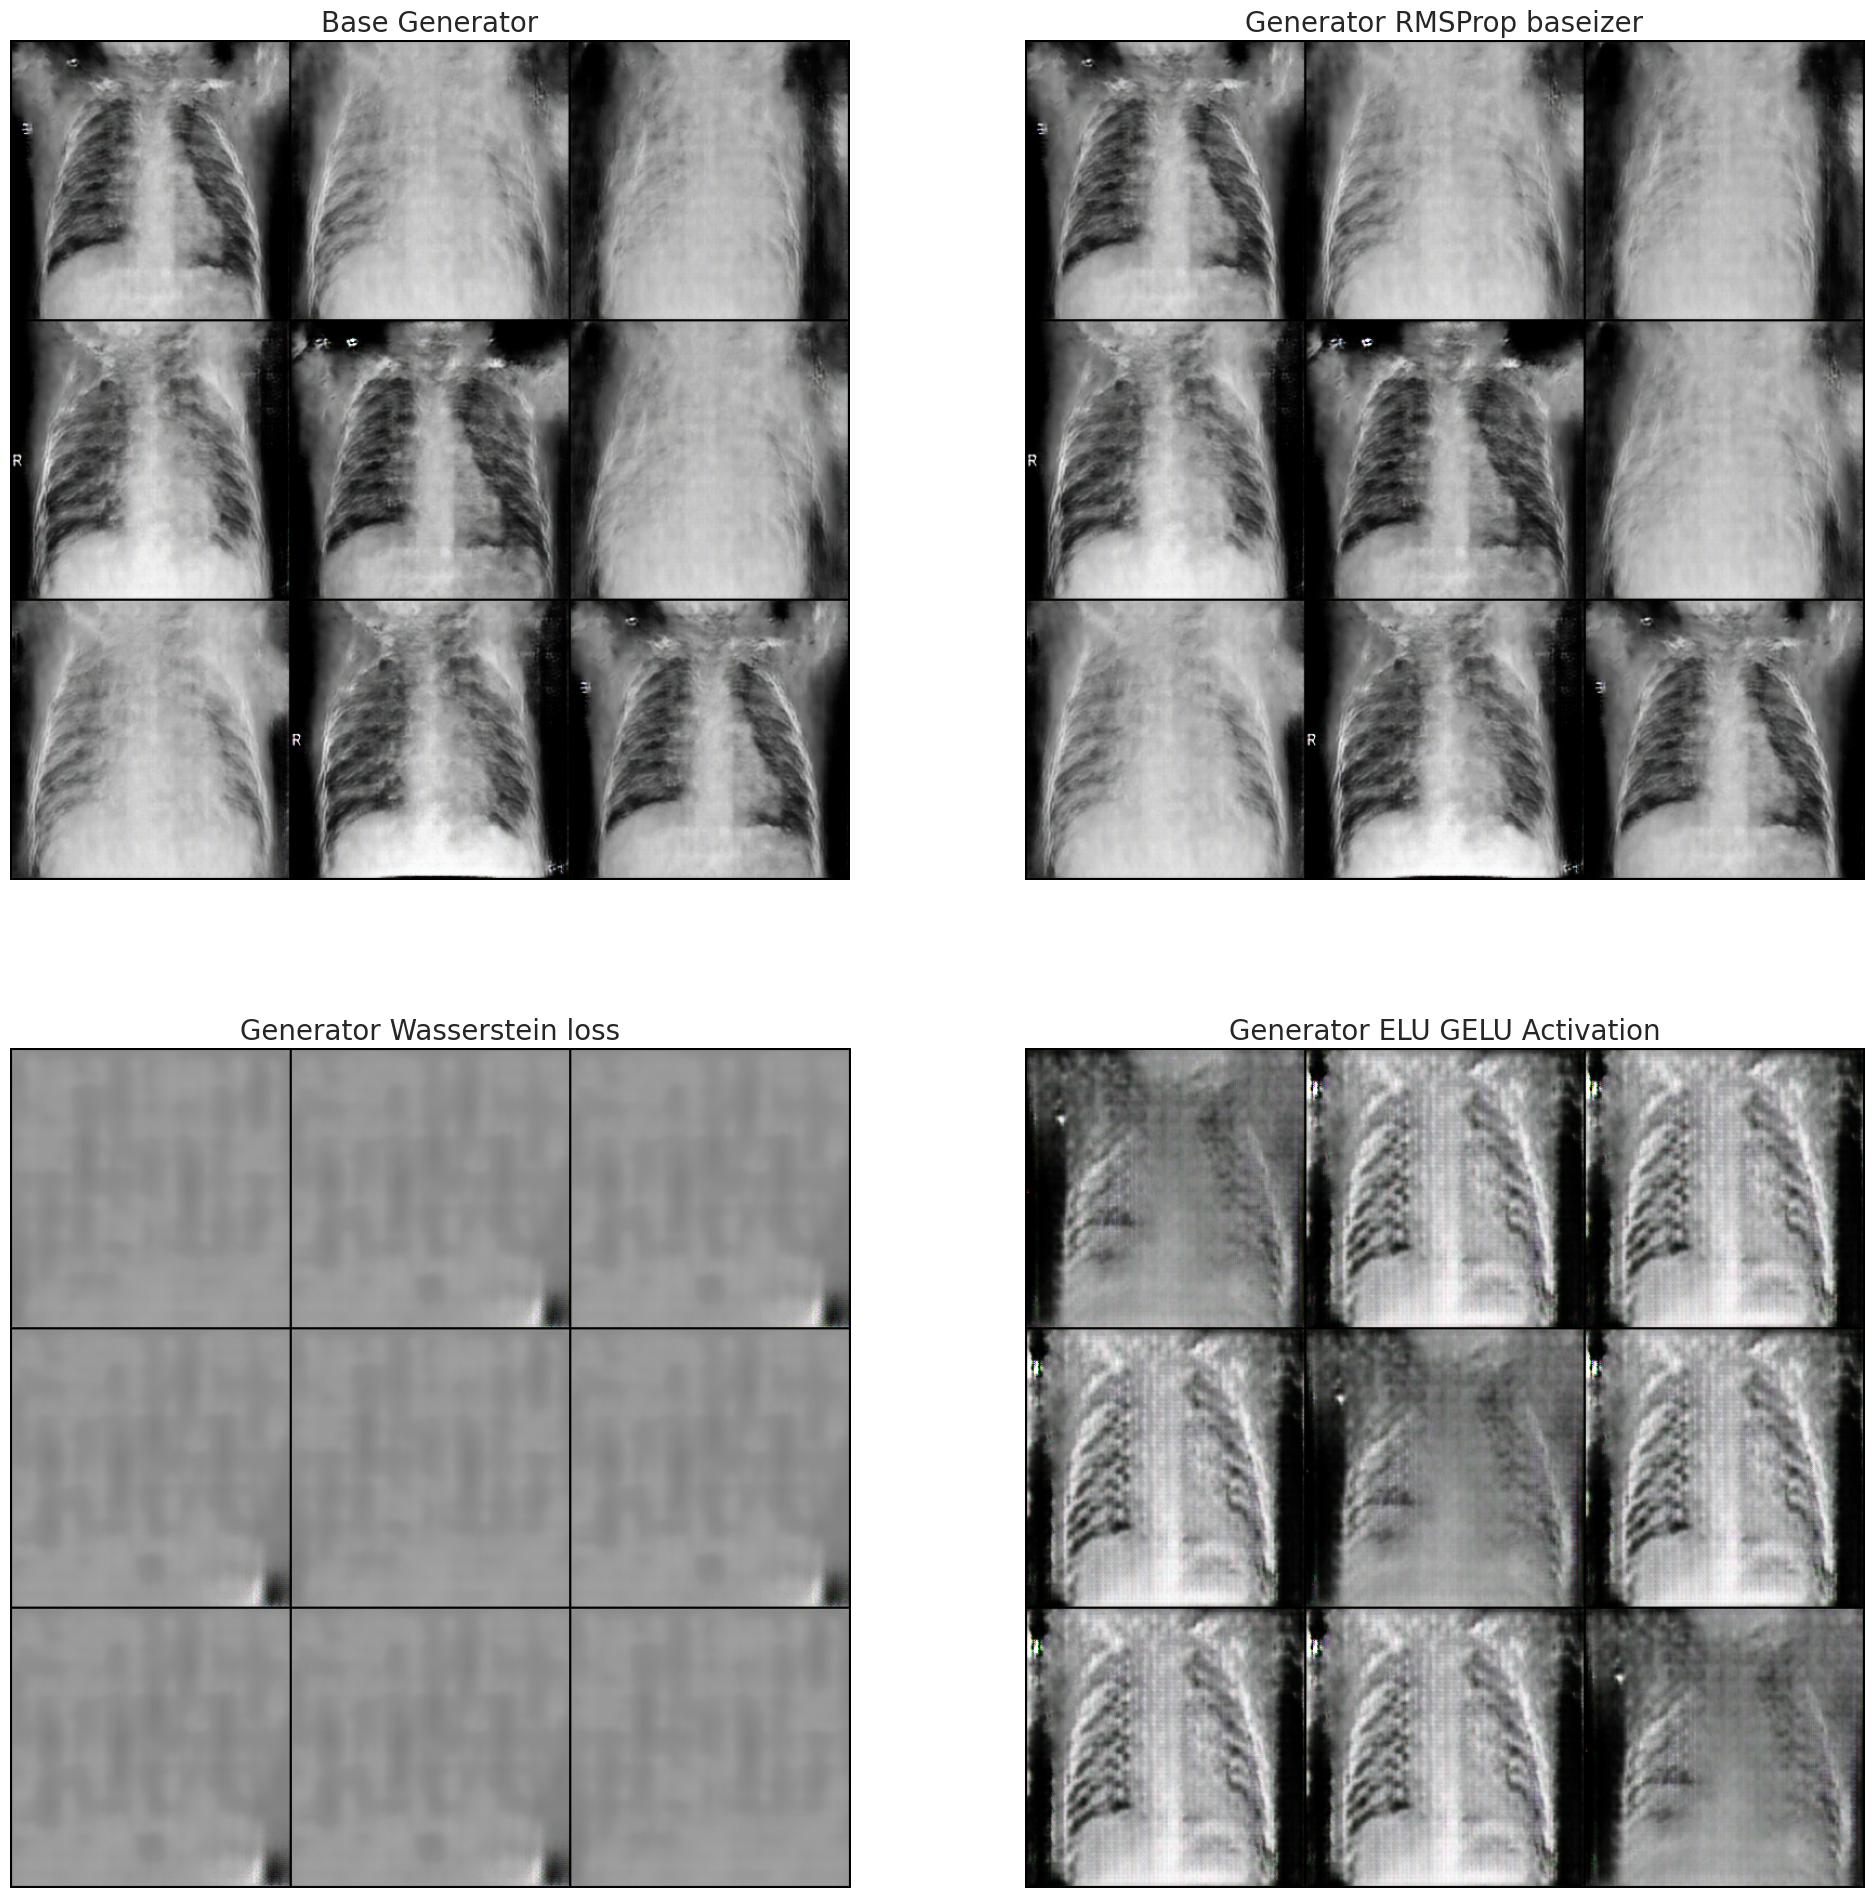

In [18]:
base_fake_images = base_gen(fixed_noise, fixed_labels)
base_fake_images = base_gen(fixed_noise, fixed_labels)
loss_fake_images = loss_gen(fixed_noise, fixed_labels)
act_fake_images = act_gen(fixed_noise, fixed_labels)

fig, axs = plt.subplots(2, 2, figsize=(24, 24))

show_tensor_images(base_fake_images, ax=axs[0,0], title="Base Generator")
show_tensor_images(base_fake_images, ax=axs[0,1], title="Generator RMSProp baseizer")
show_tensor_images(loss_fake_images, ax=axs[1,0], title="Generator Wasserstein loss")
show_tensor_images(act_fake_images, ax=axs[1,1], title="Generator ELU GELU Activation")
plt.savefig('acgan_generator_image.png')
plt.show()

In [19]:
def plot_losses(ax, g_losses, d_losses, title="", legend_title="", step_bins=20):
    num_examples = (len(g_losses) // step_bins) * step_bins
    
    ax.plot(
        range(num_examples // step_bins),
        torch.Tensor(g_losses[:num_examples]).view(-1, step_bins).mean(1),
        label=legend_title + " Generator Loss",
        linewidth=2,   
        markersize=6   
    )

    ax.plot(
        range(num_examples // step_bins),
        torch.Tensor(d_losses[:num_examples]).view(-1, step_bins).mean(1),
        label=legend_title + " Discriminator Loss",
        linewidth=2,   
        markersize=6   
    )
    
    ax.set_xlabel("Training Steps", fontsize=14)        
    ax.set_ylabel("Loss", fontsize=14)                  
    ax.set_title(title, fontsize=16, fontweight='bold')  
    ax.legend(loc='upper right', fontsize=12)          
    ax.grid(True, linestyle='--', alpha=0.7)            
    ax.tick_params(axis='both', labelsize=12)

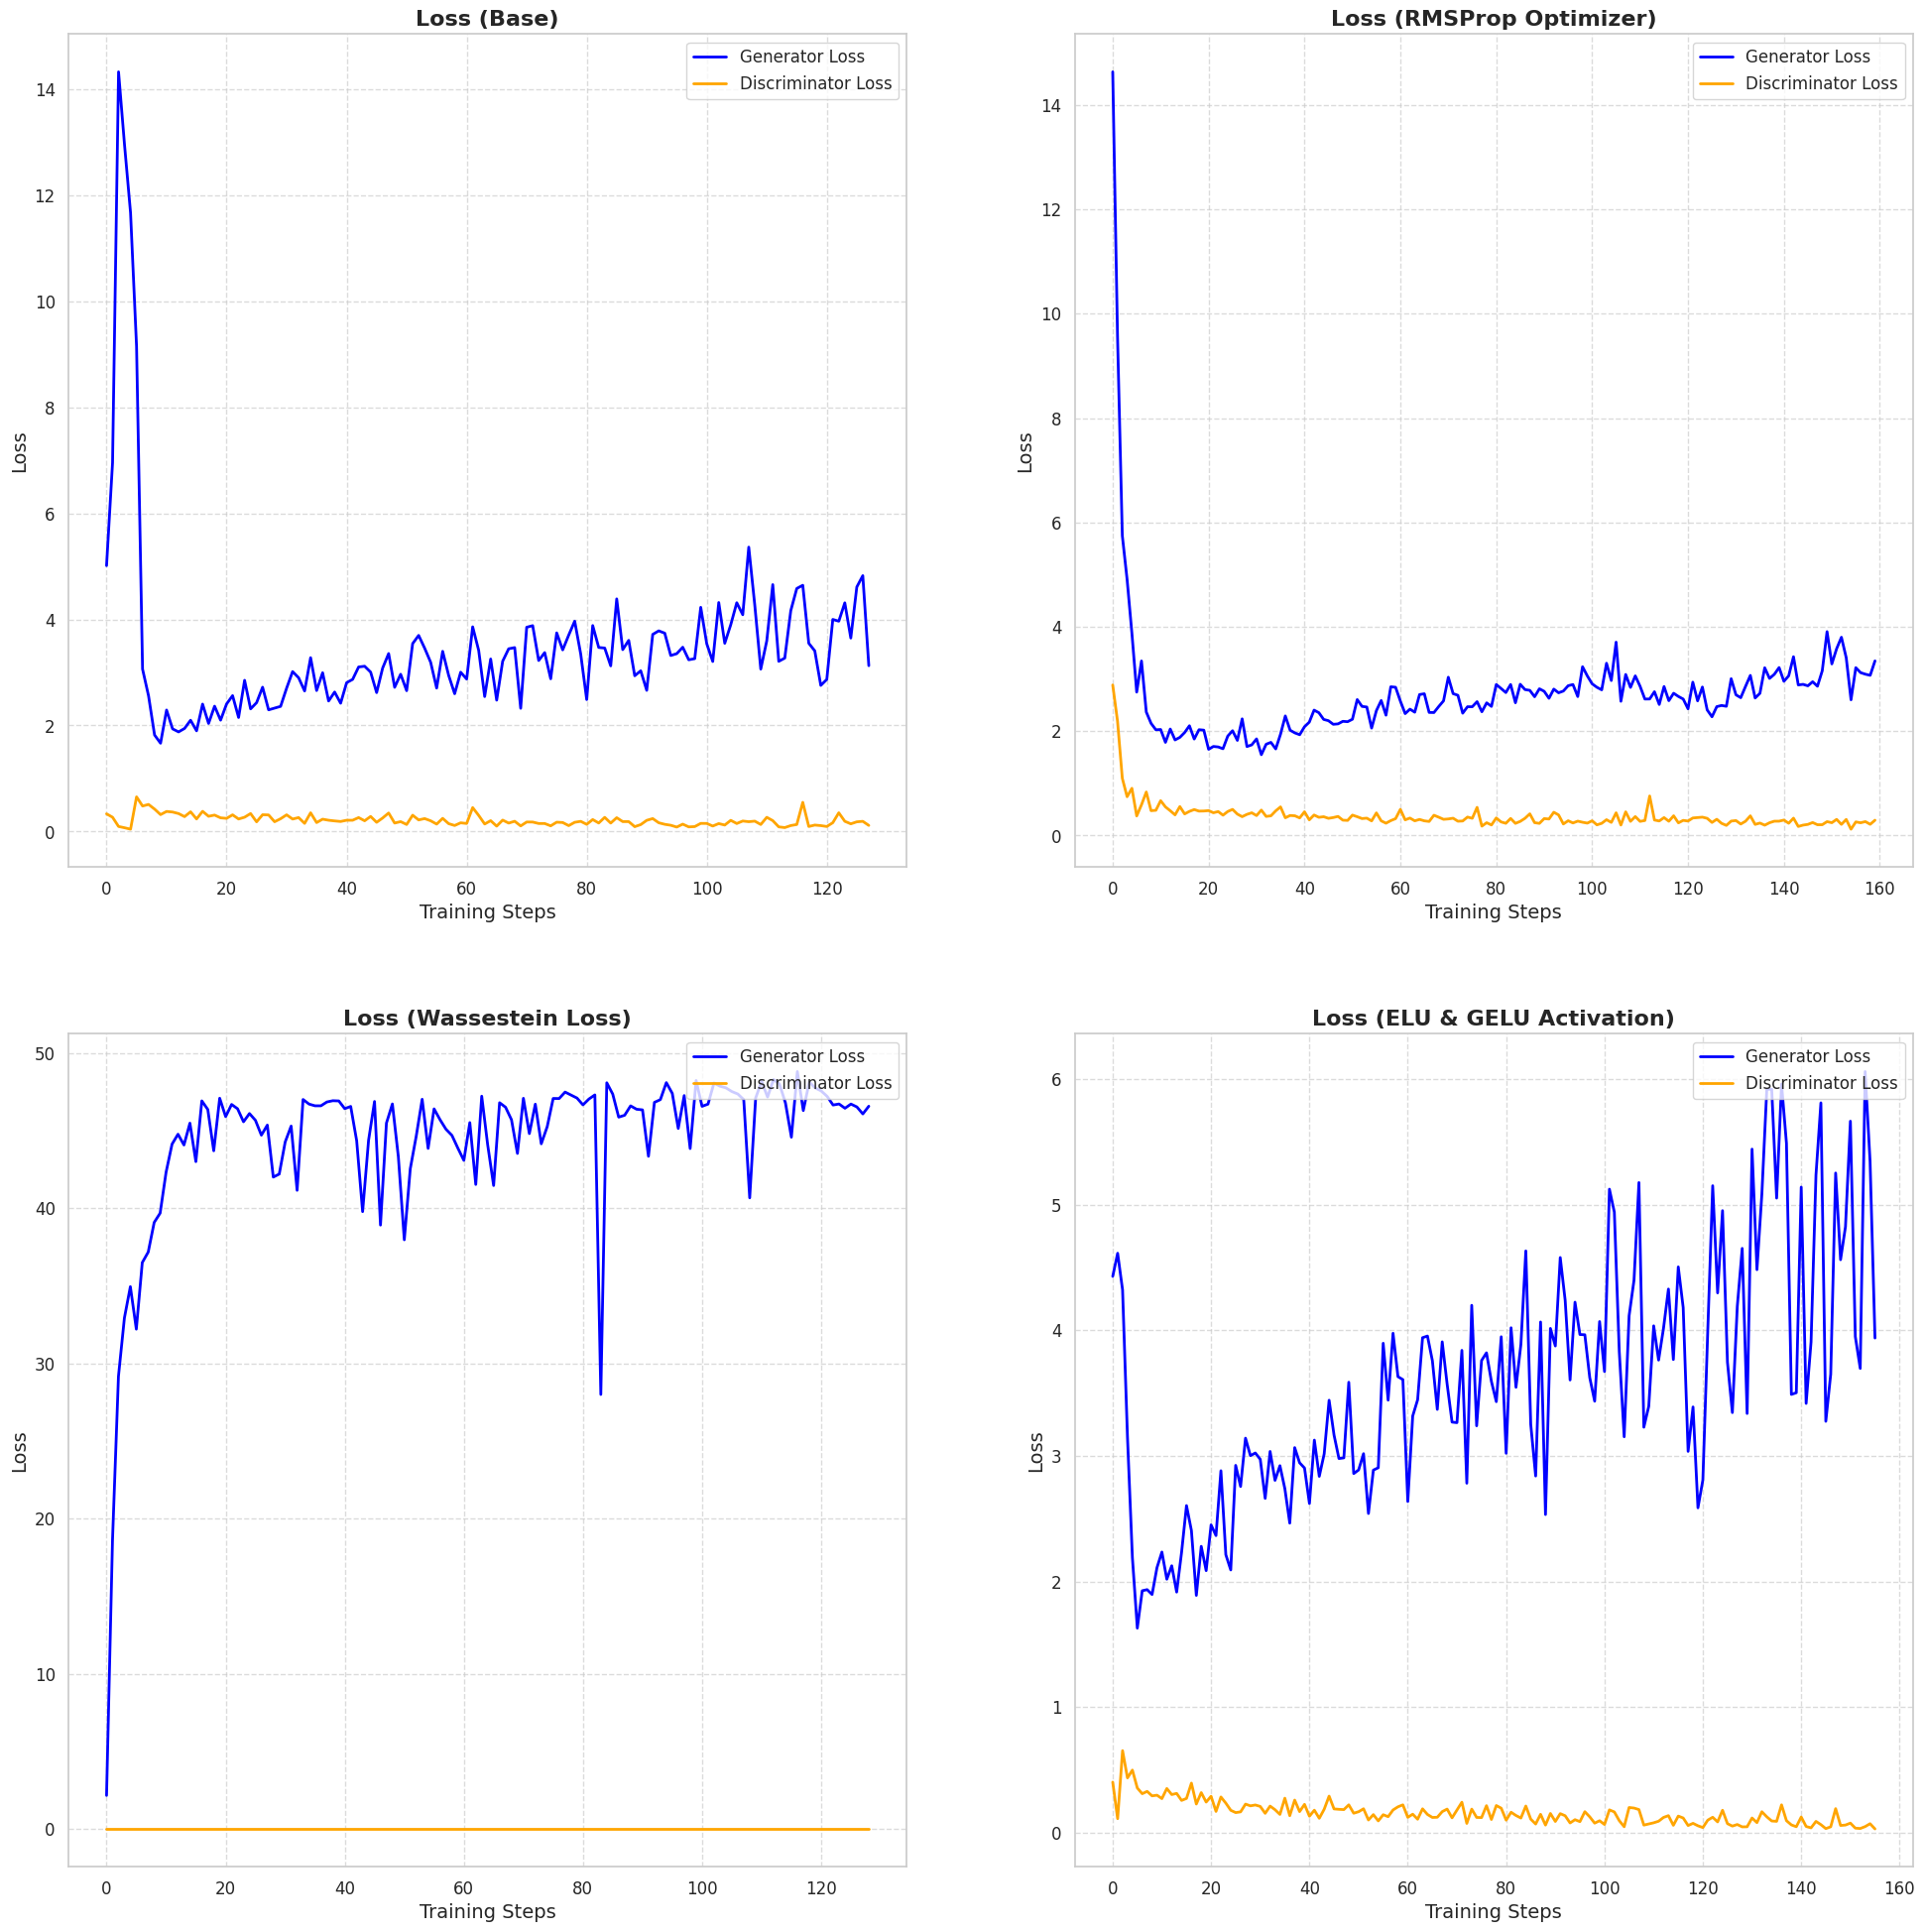

In [15]:
step_bins = 20
fig, axs = plt.subplots(2, 2, figsize=(24, 24))

plot_losses(axs[0,0], base_g_losses, base_d_losses, "Loss (Base)")
plot_losses(axs[0,1], base_g_losses, base_d_losses, "Loss (RMSProp baseizer)")
plot_losses(axs[1,0], loss_g_losses, loss_d_losses, "Loss (Wassestein Loss)")
plot_losses(axs[1,1], act_g_losses, act_d_losses, "Loss (ELU & GELU Activation)")
plt.show()

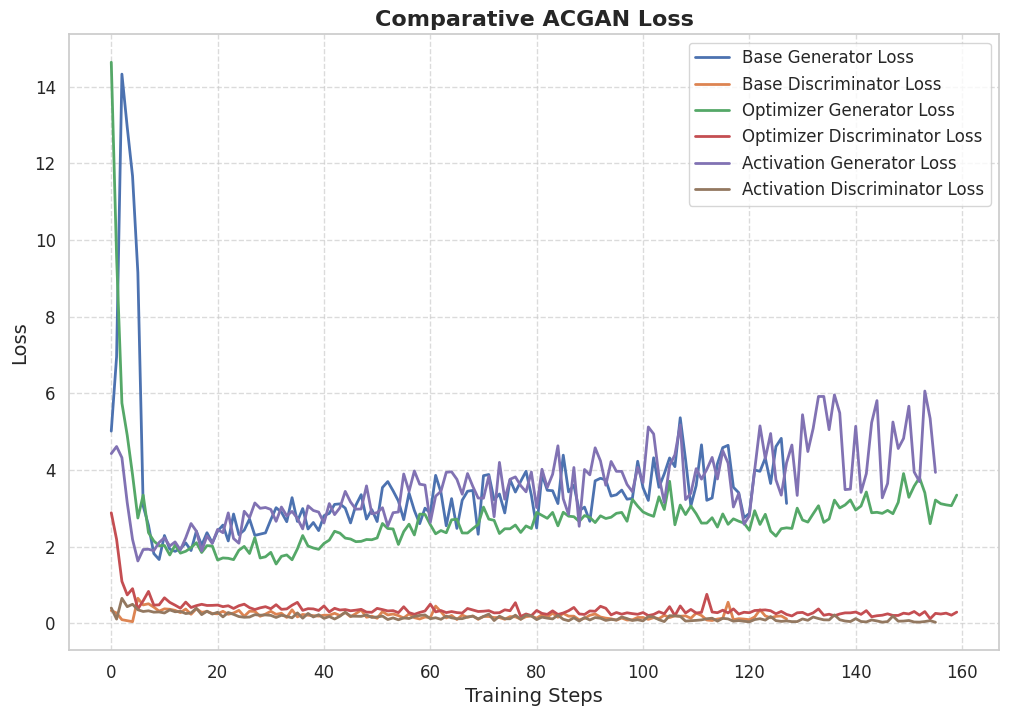

In [20]:
step_bins = 20
fig, axs = plt.subplots(1, 1, figsize=(12, 8))

plot_losses(axs, base_g_losses, base_d_losses, legend_title='Base')
plot_losses(axs, optim_g_losses, optim_d_losses, legend_title='Optimizer')
plot_losses(axs, act_g_losses, act_d_losses, "Comparative ACGAN Loss", legend_title='Activation')
plt.savefig("combined_acgan_loss.png", dpi=300, bbox_inches='tight')  
plt.show()

In [21]:
def evaluate_model(model, X_test, y_test, model_type='xgb'):
    if model_type == 'xgb':
        dtest = xgb.DMatrix(data=X_test, label=y_test)
        y_pred_prob = model.predict(dtest)
    elif model_type == 'lgb' or model_type=='clf':
        y_pred_prob = model.predict(X_test)
    else:
        raise ValueError("Unsupported model type. Use 'xgb' or 'lgb' or 'clf'.")

    y_pred = np.where(y_pred_prob > 0.5, 1, 0)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "pred":y_pred
    }

    return metrics


In [22]:
X_train,X_test,y_train,y_test = train_test_split(base_features,base_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

base_xgb_model = xgb.Booster()
base_xgb_model.load_model('/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/xgb_model.json')
base_xgb_metrics = evaluate_model(base_xgb_model, X_test, y_test, model_type='xgb')

base_lgb_model = lgb.Booster(model_file='/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/lgb_model.txt')
base_lgb_metrics = evaluate_model(base_lgb_model, X_test, y_test, model_type='lgb')

base_sclf = joblib.load('/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/stacking_classifier.pkl')
base_sclf_metrics = evaluate_model(base_sclf, X_test, y_test, model_type='clf')

In [23]:
X_train,X_test,y_train,y_test = train_test_split(optim_features,optim_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

optim_xgb_model = xgb.Booster()
optim_xgb_model.load_model('/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/xgboost_model.json')
optim_xgb_metrics = evaluate_model(optim_xgb_model, X_test, y_test, model_type='xgb')


optim_lgb_model = lgb.Booster(model_file='/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/lgbm_classifier_model.txt')
optim_lgb_metrics = evaluate_model(optim_lgb_model, X_test, y_test, model_type='lgb')

optim_sclf = joblib.load('/kaggle/input/acgan_rmsprop_100_epochs/pytorch/default/3/stacking_classifier.pkl')
optim_sclf_metrics = evaluate_model(optim_sclf, X_test, y_test, model_type='clf')

In [24]:
X_train,X_test,y_train,y_test = train_test_split(loss_features,loss_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
loss_xgb_model = xgb.Booster()
loss_xgb_model.load_model('/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/xgboost_model.json')
loss_xgb_metrics = evaluate_model(loss_xgb_model, X_test, y_test, model_type='xgb')

loss_lgb_model = lgb.Booster(model_file='/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/lgbm_classifier_model.txt')
loss_lgb_metrics = evaluate_model(loss_lgb_model, X_test, y_test, model_type='lgb')

loss_sclf = joblib.load('/kaggle/input/acgan_wasserstein_80_epochs/pytorch/default/3/stacking_classifier.pkl')
loss_sclf_metrics = evaluate_model(loss_sclf, X_test, y_test, model_type='clf')

In [25]:
X_train,X_test,y_train,y_test = train_test_split(act_features,act_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

act_xgb_model = xgb.Booster()
act_xgb_model.load_model('/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/xgb_model.json')
act_xgb_metrics = evaluate_model(act_xgb_model, X_test, y_test, model_type='xgb')

act_lgb_model = lgb.Booster(model_file='/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/lgb_model.txt')
act_lgb_metrics = evaluate_model(act_lgb_model, X_test, y_test, model_type='lgb')

act_sclf = joblib.load('/kaggle/input/acgan_activation_100epcohs/pytorch/default/2/stacking_classifier.pkl')
act_sclf_metrics = evaluate_model(act_sclf, X_test, y_test, model_type='clf')

In [30]:
def highlight_best_average(df):
    avg_acc = df.groupby('Feature Set')['Accuracy (%)'].mean()
    max_feature_set = avg_acc.idxmax()

    def highlight_feature_set(row):
        return ['background-color: darkgreen' if row.name[0] == max_feature_set else '' for _ in row]
    
    return df.style.apply(highlight_feature_set, axis=1)

# Create a metrics DataFrame
def create_metrics_dataframe(metrics_dicts, model_names, feature_sets):
    results = []
    for metrics, model_name, feature_set in zip(metrics_dicts, model_names, feature_sets):
        result = {
            "Model": model_name,
            "Precision": metrics['Precision'],
            "Recall": metrics['Recall'],
            "F1 Score": metrics['F1 Score'],
            "Accuracy (%)": metrics['Accuracy'] * 100,
        }
        results.append(result)

    df = pd.DataFrame(results)

    df['Feature Set'] = feature_sets
    df.set_index(['Feature Set', 'Model'], inplace=True)

    metrics_df = highlight_best_average(df).format({
        "Accuracy (%)": "{:.2f}",
        "Precision": "{:.2f}",
        "Recall": "{:.2f}",
        "F1 Score": "{:.2f}"
    }).set_table_styles(
        [{
            'selector': 'thead th',
            'props': [('background-color', '#40466e'), 
                      ('color', 'white'),
                      ('font-weight', 'bold'),
                      ('font-size', '18px')]
        },{
            'selector': 'tbody td',
            'props': [('padding', '10px'),
                      ('font-size', '15px')]
        }]
    ).set_properties(
        **{'width': '200px', 'border': '1px solid #b9b9b9'}  
    )
    
    return metrics_df

In [31]:
metrics_dicts = [
    base_xgb_metrics, base_lgb_metrics, base_sclf_metrics,
    optim_xgb_metrics, optim_lgb_metrics, optim_sclf_metrics,
    loss_xgb_metrics, loss_lgb_metrics, loss_sclf_metrics,
    act_xgb_metrics, act_lgb_metrics, act_sclf_metrics,
]

model_names = [
    "XGBoost", "LightGBM", "Stacking Classifier",
    "XGBoost", "LightGBM", "Stacking Classifier",
    "XGBoost", "LightGBM", "Stacking Classifier",
    "XGBoost", "LightGBM", "Stacking Classifier",
]

feature_sets = [
    "Base", "Base", "Base",
    "Optimized", "Optimized", "Optimized",
    "Loss", "Loss", "Loss",
    "Activation", "Activation", "Activation",
]
df_results = create_metrics_dataframe(metrics_dicts, model_names, feature_sets)
df_results

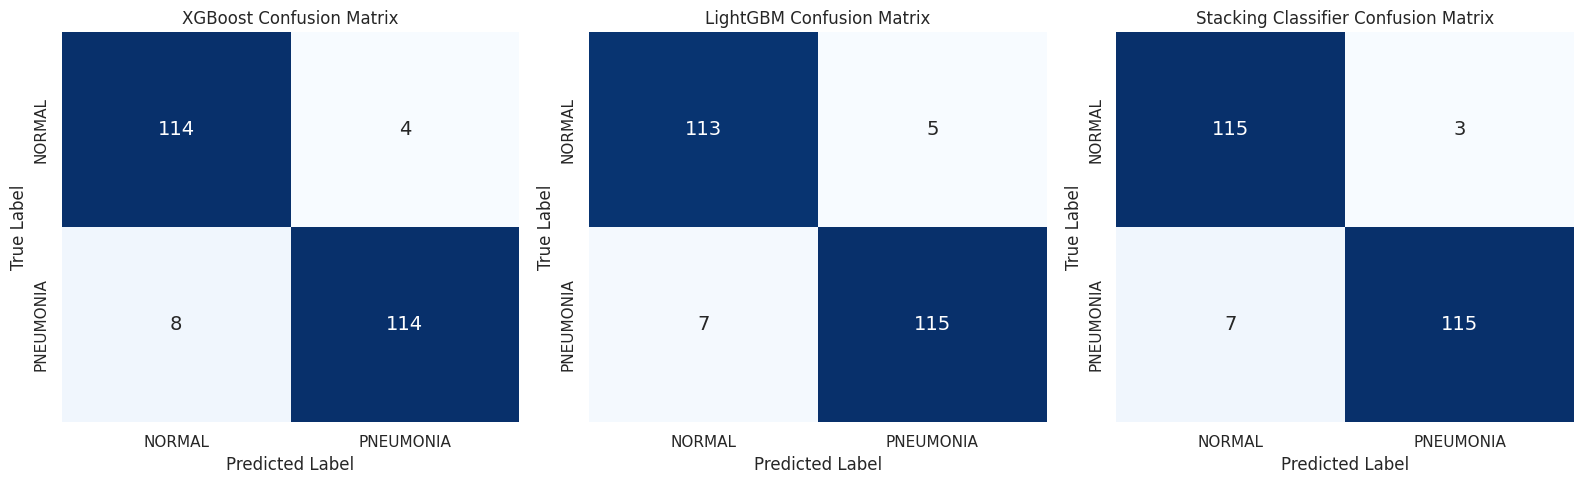

In [26]:
X_train,X_test,y_train,y_test = train_test_split(base_features,base_labels,test_size=0.2,random_state=42)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

base_xgb_model = xgb.Booster()
base_xgb_model.load_model('/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/xgb_model.json')
base_xgb_metrics = evaluate_model(base_xgb_model, X_test, y_test, model_type='xgb')

base_lgb_model = lgb.Booster(model_file='/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/lgb_model.txt')
base_lgb_metrics = evaluate_model(base_lgb_model, X_test, y_test, model_type='lgb')

base_sclf = joblib.load('/kaggle/input/256x256_acgan_80epochs/pytorch/default/2/stacking_classifier.pkl')
base_sclf_metrics = evaluate_model(base_sclf, X_test, y_test, model_type='clf')

labels = ["NORMAL", "PNEUMONIA"]

xgb_conf_matrix = confusion_matrix(y_test, base_xgb_metrics['pred'])
lgb_conf_matrix = confusion_matrix(y_test, base_lgb_metrics['pred'])
sclf_conf_matrix = confusion_matrix(y_test, base_sclf_metrics['pred'])

def beautify_confusion_matrix(ax, matrix, model_name, labels):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=labels, yticklabels=labels, annot_kws={"size": 14}, ax=ax)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

beautify_confusion_matrix(axes[0], xgb_conf_matrix, "XGBoost", labels)
beautify_confusion_matrix(axes[1], lgb_conf_matrix, "LightGBM", labels)
beautify_confusion_matrix(axes[2], sclf_conf_matrix, "Stacking Classifier", labels)
plt.tight_layout()
plt.savefig("combined_acgan_classifier_conf_matrix.png", dpi=300, bbox_inches='tight')  
plt.show()

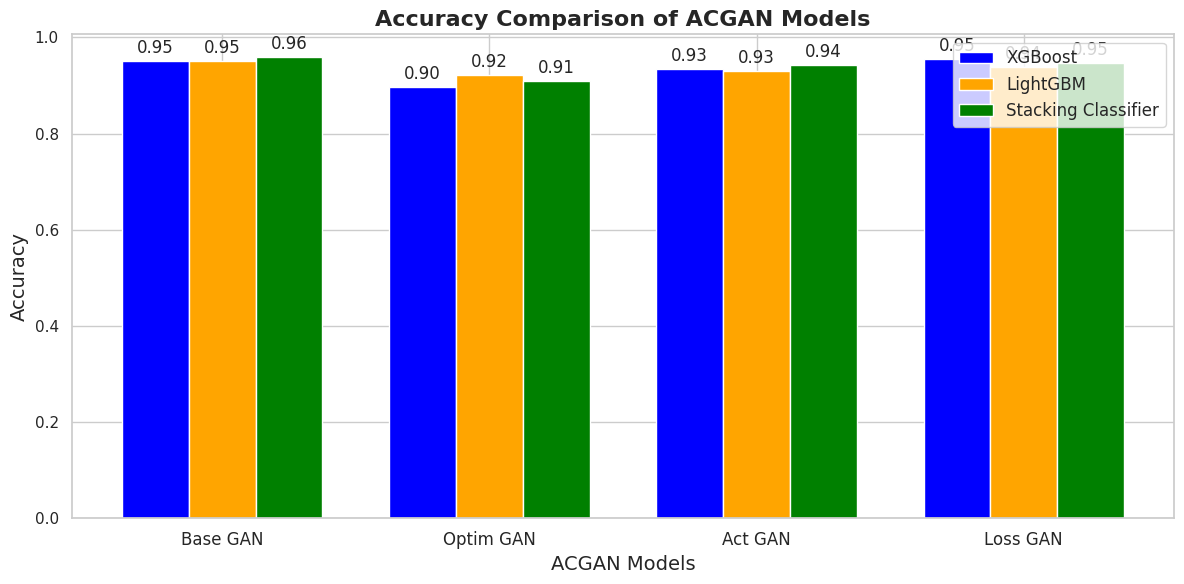

In [27]:
labels = ['Base GAN', 'Optim GAN', 'Act GAN', 'Loss GAN']
xgb_accuracies = [base_xgb_metrics["Accuracy"], optim_xgb_metrics["Accuracy"], 
                  act_xgb_metrics["Accuracy"], loss_xgb_metrics["Accuracy"]]

lgb_accuracies = [base_lgb_metrics["Accuracy"], optim_lgb_metrics["Accuracy"], 
                  act_lgb_metrics["Accuracy"], loss_lgb_metrics["Accuracy"]]

sclf_accuracies = [base_sclf_metrics["Accuracy"], optim_sclf_metrics["Accuracy"], 
                  act_sclf_metrics["Accuracy"], loss_sclf_metrics["Accuracy"]]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, xgb_accuracies, width, label='XGBoost', color='blue')
rects2 = ax.bar(x, lgb_accuracies, width, label='LightGBM', color='orange')
rects3 = ax.bar(x + width, sclf_accuracies, width, label='Stacking Classifier', color='green')

ax.set_xlabel('ACGAN Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy Comparison of ACGAN Models', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',  
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.savefig("combined_acgan_classifier_accuracies.png", dpi=300, bbox_inches='tight')  
plt.show()

In [28]:
def convert_to_dtest(X_test, y_test):
    return xgb.DMatrix(X_test, label=y_test)
def plot_roc_curve(models, model_names, features, labels, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for i, model in enumerate(models):
        X_train, X_test, y_train, y_test = train_test_split(
            features[i], labels[i], test_size=0.2, random_state=42
        )
        
        if "XGBoost" in model_names[i]:
            dtest = convert_to_dtest(X_test, y_test)
            y_pred_prob = model.predict(dtest)
        else:
            y_pred_prob = model.predict(X_test)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_names[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Comparative ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.savefig("combined_acgan_roc.png", dpi=300, bbox_inches='tight')  
    plt.show()

def plot_precision_recall_curve(models, model_names, features, labels, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for i, model in enumerate(models):
        X_train, X_test, y_train, y_test = train_test_split(
            features[i], labels[i], test_size=0.2, random_state=42
        )
        
        if "XGBoost" in model_names[i]:
            dtest = convert_to_dtest(X_test, y_test)
            y_pred_prob = model.predict(dtest)
        else:
            y_pred_prob = model.predict(X_test)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        plt.plot(recall, precision, label=f'{model_names[i]}')

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title('Comparative Precision-Recall Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="best", fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.7)
    plt.savefig("combined_acgan_pcr.png", dpi=300, bbox_inches='tight')  
    plt.show()


In [29]:
models = [
    base_xgb_model, base_lgb_model, base_sclf,
    optim_xgb_model, optim_lgb_model, optim_sclf,
    loss_xgb_model, loss_lgb_model, loss_sclf,
    act_xgb_model, act_lgb_model, act_sclf,
]

model_names = [
    "Base XGBoost", "Base LightGBM", "Base Stacking Classifier",
    "Optim XGBoost", "Optim LightGBM", "Optim Stacking Classifier",
    "Loss XGBoost", "Loss LightGBM", "Loss Stacking Classifier",
    "Act XGBoost", "Act LightGBM", "Act Classifier",
]

# Define features and labels
features = [
    base_features, base_features, base_features,
    optim_features, optim_features, optim_features,
    loss_features, loss_features, loss_features,
    act_features, act_features, act_features,
]

labels = [
    base_labels, base_labels, base_labels,
    optim_labels, optim_labels, optim_labels,
    loss_labels, loss_labels, loss_labels,
    act_labels, act_labels, act_labels,
]

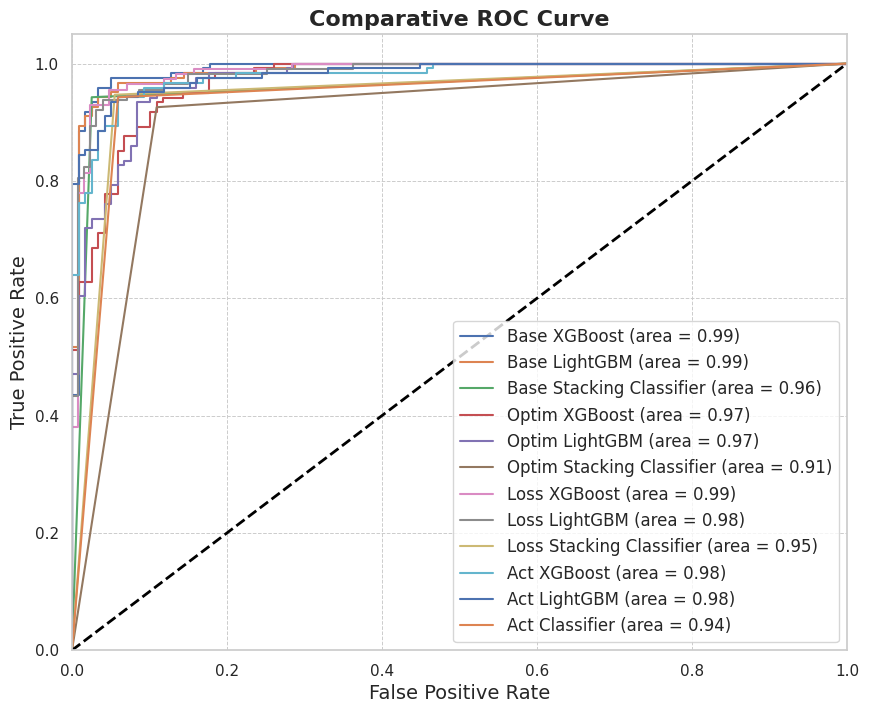

In [30]:
plot_roc_curve(models, model_names, features, labels)

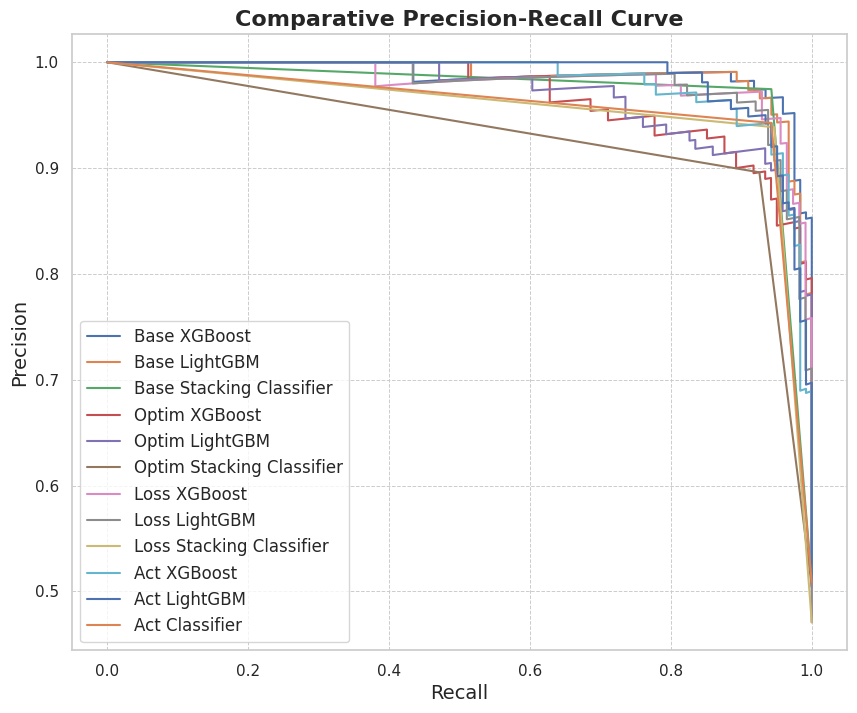

In [31]:
plot_precision_recall_curve(models, model_names, features, labels)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(base_features)

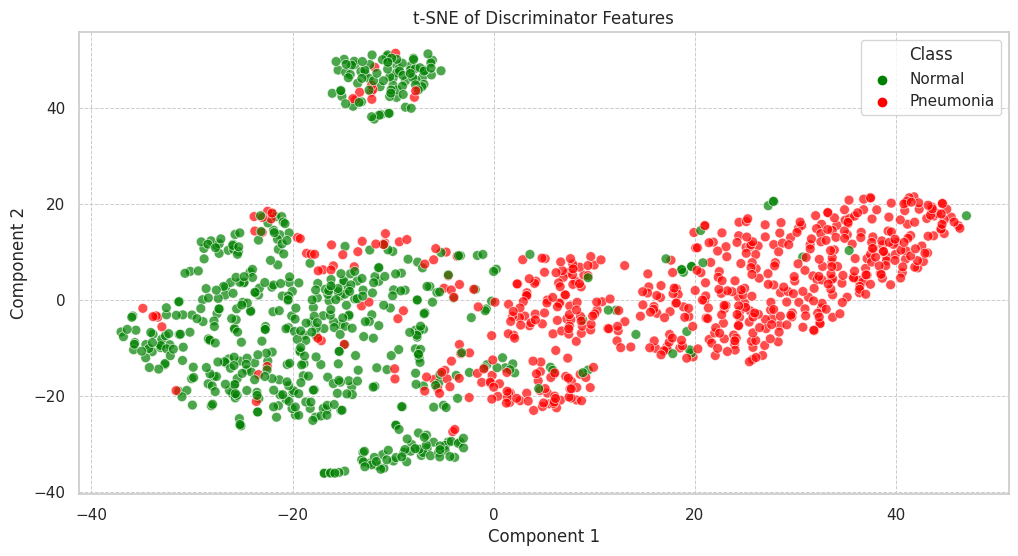

In [24]:
df_tsne = pd.DataFrame({
    'Component 1': features_tsne[:, 0],
    'Component 2': features_tsne[:, 1],
    'Label': np.where(base_labels == 0, 'Normal', 'Pneumonia') 
})

custom_palette = {'Normal': 'green', 'Pneumonia': 'red'}

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_tsne, x='Component 1', y='Component 2', hue='Label', palette=custom_palette, s=50, alpha=0.7)

plt.title('t-SNE of Discriminator Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True, linestyle='--', linewidth=0.7)

plt.legend(title='Class')
plt.savefig("tsne_features.png", dpi=300, bbox_inches='tight')  
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
features_tsne_3d = tsne.fit_transform(base_features)

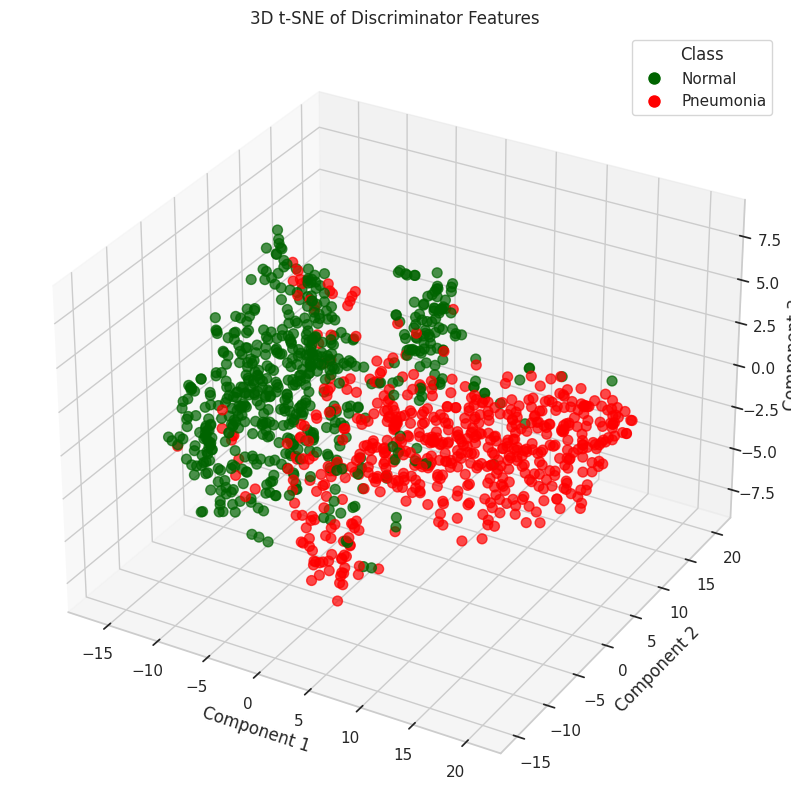

In [27]:
custom_palette = {'Normal': 'darkgreen', 'Pneumonia': 'red'}

df_tsne_3d = pd.DataFrame({
    'Component 1': features_tsne_3d[:, 0],
    'Component 2': features_tsne_3d[:, 1],
    'Component 3': features_tsne_3d[:, 2],
    'Label': np.where(base_labels == 0, 'Normal', 'Pneumonia')  
})
# Plot t-SNE in 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_tsne_3d['Component 1'], df_tsne_3d['Component 2'], df_tsne_3d['Component 3'],
                     c=df_tsne_3d['Label'].map(custom_palette), s=50, alpha=0.7)

# Add labels and title
ax.set_title('3D t-SNE of Discriminator Features')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=custom_palette[label], markersize=10) for label in custom_palette]
ax.legend(handles, custom_palette.keys(), title='Class')
plt.savefig("tsne_features_3d.png", dpi=300, bbox_inches='tight')  
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
features_tsne_3d = tsne.fit_transform(base_features)

In [45]:
df_tsne_3d = pd.DataFrame({
    'Component 1': features_tsne_3d[:, 0],
    'Component 2': features_tsne_3d[:, 1],
    'Component 3': features_tsne_3d[:, 2],
    'Label': np.where(base_labels == 0, 'Normal', 'Pneumonia')  
})

color_map = {'Normal': 'darkgreen', 'Pneumonia': 'red'}

fig_tsne = px.scatter_3d(df_tsne_3d, x='Component 1', y='Component 2', z='Component 3', 
                         color='Label', color_discrete_map=color_map,
                         title='3D t-SNE of Discriminator Features',
                         labels={'Component 1': 'Component 1', 'Component 2': 'Component 2', 'Component 3': 'Component 3'})

fig_tsne.update_traces(marker=dict(size=5))
fig_tsne.update_layout(scene=dict(
    xaxis_title='Component 1',
    yaxis_title='Component 2',
    zaxis_title='Component 3'
))

fig_tsne.show()